In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression

from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBRegressor

from sklearn import metrics
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Importing match datasets (All data downloaded from https://oracleselixir.com/tools/downloads)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# importing datasets
df2022 = pd.read_csv('datasets/2022_LoL_esports_match_data_from_OraclesElixir.csv')
df2021 = pd.read_csv('datasets/2021_LoL_esports_match_data_from_OraclesElixir.csv')

C:\Users\jrh25\AppData\Local\Temp\ipykernel_9316\3959238060.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2022 = pd.read_csv('datasets/2022_LoL_esports_match_data_from_OraclesElixir.csv')


Decided to work with the 2022 dataset. Cleaning the dataset by removing columns with missing/irrelevant data, and narrowing the focus of the dataset to whole teams instead of individual players. Focusing on nuances in individual player performance would overcomplicate the process. While looking at how team compositions using different champions has merit, that is also better saved for after optimizing the ML model on universal game factors (creep score, damage dealt, deaths per team, gold differences, etc.

In [5]:
# function to clean data, remove columns with large amounts of missing values, and remove columns that contain irrelevant/low impact data
def clean_data(df) -> pd.core.frame.DataFrame:
    extraneous = ['datacompleteness', 'league', 'year', 'split', 'playoffs', 'date', 'position',
              'url', 'playerid', 'teamid', 'patch', 'index', 'game', 'participantid', 'playername',
              ]
    low_impact = ['doublekills', 'triplekills', 'quadrakills', 'pentakills', 'infernals', 'mountains',
              'clouds', 'oceans', 'elders', 'opp_elders']
    remove_cols = extraneous + low_impact
    df = df[(df['datacompleteness'] == 'complete') &
                (df['position'] == 'team')].reset_index()
    return df.drop(columns=remove_cols).dropna(axis=1)


In [6]:
df2022 = pd.DataFrame(clean_data(df2022))

Breaking down potential features into categorical and numerical lists, removing categorical features with high cardinality and removing the 'result' column from numerical.

In [45]:
categorical = [cname for cname in df2022.columns if df2022[cname].nunique() < 10 and df2022[cname].dtype == 'object']
numerical = [cname for cname in df2022.columns if df2022[cname].dtype in ['int64', 'float64']]
numerical.remove('result')
features = categorical + numerical

In [46]:
# discerning discrete and continuous quantities in features
disc_features = ['kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'firstblood', 'firstdragon', 'dragons',
'opp_dragons', 'firstherald', 'heralds', 'opp_heralds', 'firstbaron', 'barons', 'opp_barons', 'firsttower', 'towers', 'firsttothreetowers',
'opp_towers', 'inhibitors', 'opp_inhibitors', 'wardsplaced', 'wardskilled', 'controlwardsbought', 'visionscore']
cont_features = [i for i in features if (i not in disc_features) and (i not in categorical)]

Beginning exploratory data analysis

In [9]:
df2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21216 entries, 0 to 21215
Data columns (total 76 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gameid                    21216 non-null  object 
 1   side                      21216 non-null  object 
 2   gamelength                21216 non-null  int64  
 3   result                    21216 non-null  int64  
 4   kills                     21216 non-null  int64  
 5   deaths                    21216 non-null  int64  
 6   assists                   21216 non-null  int64  
 7   teamkills                 21216 non-null  int64  
 8   teamdeaths                21216 non-null  int64  
 9   firstblood                21216 non-null  float64
 10  team kpm                  21216 non-null  float64
 11  ckpm                      21216 non-null  float64
 12  firstdragon               21216 non-null  float64
 13  dragons                   21216 non-null  float64
 14  opp_dr

In [10]:
df2022.head()

,gameid,side,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,firstblood,team kpm,ckpm,firstdragon,dragons,opp_dragons,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,Blue,1713,0,9,19,19,9,19,1.0,0.3152,0.9807,0.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,1.0,0.0,1.0,56560.0,1981.0858,3537.1979,2364.7285,74.0,2.5919,51.0,1.7863,33.0,197.0,6.9002,47070,28222.0,988.5114,44570.0,-0.028312,680.0,160.0,29.4221,16218.0,18213.0,322.0,14695.0,18076.0,330.0,1523.0,137.0,-8.0,3.0,5.0,0.0,0.0,0.0,3.0,24806.0,28001.0,487.0,24699.0,29618.0,510.0,107.0,-1617.0,-23.0,5.0,10.0,6.0,6.0,18.0,5.0
1,ESPORTSTMNT01_2690210,Red,1713,1,19,9,62,19,9,0.0,0.6655,0.9807,1.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,1.0,0.0,79912.0,2799.0193,3009.6673,2872.3292,93.0,3.2574,51.0,1.7863,45.0,205.0,7.1804,52617,33769.0,1182.8021,45850.0,0.028312,792.0,184.0,34.1856,14695.0,18076.0,330.0,16218.0,18213.0,322.0,-1523.0,-137.0,8.0,0.0,0.0,3.0,3.0,5.0,0.0,24699.0,29618.0,510.0,24806.0,28001.0,487.0,-107.0,1617.0,23.0,6.0,18.0,5.0,5.0,10.0,6.0
2,ESPORTSTMNT01_2690219,Blue,2114,0,3,16,7,3,16,0.0,0.0851,0.5393,0.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,3.0,11.0,0.0,0.0,2.0,59579.0,1690.9839,2984.0208,3109.6121,119.0,3.3775,55.0,1.5610,47.0,277.0,7.8619,57629,34688.0,984.5222,53945.0,-0.207137,994.0,215.0,34.3141,14939.0,17462.0,317.0,16558.0,19048.0,344.0,-1619.0,-1586.0,-27.0,1.0,1.0,3.0,3.0,3.0,1.0,23522.0,28848.0,533.0,25285.0,29754.0,555.0,-1763.0,-906.0,-22.0,1.0,1.0,3.0,3.0,3.0,1.0
3,ESPORTSTMNT01_2690219,Red,2114,1,16,3,39,16,3,1.0,0.4541,0.5393,1.0,4.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,11.0,3.0,1.0,2.0,0.0,74855.0,2124.5506,2745.7237,2868.4201,129.0,3.6613,70.0,1.9868,65.0,346.0,9.8202,71004,48063.0,1364.1343,66410.0,0.207137,1013.0,244.0,35.6764,16558.0,19048.0,344.0,14939.0,17462.0,317.0,1619.0,1586.0,27.0,3.0,3.0,1.0,1.0,1.0,3.0,25285.0,29754.0,555.0,23522.0,28848.0,533.0,1763.0,906.0,22.0,3.0,3.0,1.0,1.0,1.0,3.0
4,ESPORTSTMNT01_2690227,Blue,1972,1,14,5,42,14,5,0.0,0.4260,0.5781,1.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,11.0,2.0,1.0,2.0,0.0,67376.0,2049.9797,2327.8905,1776.2677,119.0,3.6207,51.0,1.5517,68.0,264.0,8.0325,62868,41372.0,1258.7830,57615.0,0.165672,874.0,269.0,34.7769,15466.0,19600.0,368.0,15569.0,18787.0,355.0,-103.0,813.0,13.0,0.0,0.0,1.0,1.0,1.0,0.0,24795.0,31342.0,560.0,23604.0,29044.0,545.0,1191.0,2298.0,15.0,3.0,8.0,1.0,1.0,1.0,3.0


In [11]:
df2022.shape

(21216, 76)

Analyzing effects of categorical variables (team side being the sole column) on each team's result. There will be no difference in the distribution of the team sides themselves: we expect an even 50% distribution of both red and blue sided teams, since the dataset contains match data for each pair of opposing teams in each match. 
What we can do instead is plot histograms showing the distribution of wins for red and blue sides respectively. The resulting plot supports the starting assumption that the blue side has a subtle advantage over the red side.

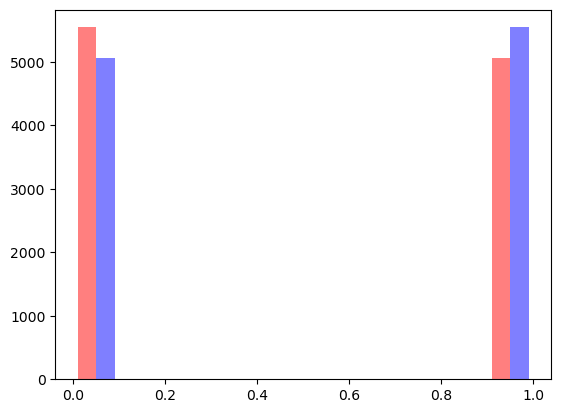

In [12]:
plt.hist([df2022[df2022.side=='Red'].result, df2022[df2022.side=='Blue'].result], color=['r', 'b'], alpha=0.5);


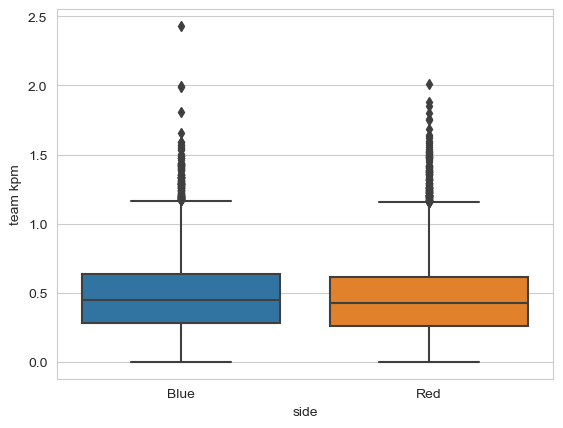

In [13]:
sns.set_style("whitegrid")  
fig, axs = plt.subplots()
#sns.boxplot(y='gamelength', data=df2022, ax=axs)
sns.boxplot(x='side', y='team kpm', data=df2022, ax=axs);

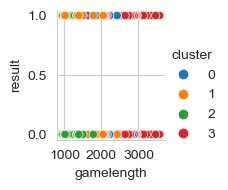

In [14]:
kmeans = KMeans(n_clusters=4)
df2022['cluster'] = kmeans.fit_predict(df2022[numerical])
df2022['cluster'] = df2022['cluster'].astype("category")
sns.relplot(
    data=df2022, x='gamelength', y='result', hue='cluster', height=2
);

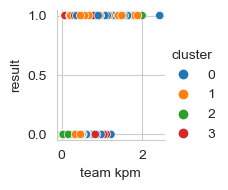

In [15]:
sns.relplot(
    data=df2022, x='team kpm', y='result', hue='cluster', height=2
);

In [16]:
# splitting data into training and validation parts
y = df2022.result
X = df2022[features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [49]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
mi_scores = make_mi_scores(X, y, disc_features)
mi_scores

ValueError: could not convert string to float: 'Blue'

In [166]:
# defining preprocessing steps
# no missing values in cleaned dataset, so no need for an imputer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)
    ]
)

model = RandomForestClassifier(n_estimators=100, random_state=None)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)

In [164]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2107
           1       0.53      0.52      0.53      2137

    accuracy                           0.53      4244
   macro avg       0.53      0.53      0.53      4244
weighted avg       0.53      0.53      0.53      4244



In [165]:
scores = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
print("Precision scores:\n", scores)

Precision scores:
 [0.50848256 0.50636492 0.53179463 0.53088166 0.53653937]
